In [3]:

import os
import dotenv

from typing import TypedDict, List, Literal, Any
from pprint import pprint
from tavily import TavilyClient

from langchain.document_loaders import WebBaseLoader
from langchain.prompts import PromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langgraph.graph import END, StateGraph

from langsmith.wrappers import wrap_openai
from langsmith import traceable

from IPython.display import display, Image, JSON
dotenv.load_dotenv()

True

In [4]:
# 전역변수, API 설정
LLM = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o-mini")
EMBEDDING = OpenAIEmbeddings(api_key=os.getenv(
    "OPENAI_API_KEY"), model="text-embedding-3-small")
LOADER = WebBaseLoader([
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
])
SPLITTER = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=32)
DOCUMENTS = SPLITTER.split_documents(LOADER.load())
VECTOR_DB = FAISS.from_documents(DOCUMENTS, EMBEDDING)
VECTOR_RETRIEVER = VECTOR_DB.as_retriever()

TAVILY = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [5]:
# 타입 정의
ROUTING = Literal['WEB', 'VECTOR']
ROUTING_REDO = Literal['WEB', 'VECTOR', 'END']

class Output(TypedDict):
    generated: str
    reason: str
    reason_url: str
    hallucination: bool
    hallucination_comment: str

class GraphState(TypedDict):
    input: str
    output: Output
    output_history: List[Output]

    routing: ROUTING

In [6]:
# node 정의
def route_expert(state: GraphState) -> ROUTING:
    parser = StrOutputParser()
    prompt = PromptTemplate(
        template="""
You are an expert at routing a user question to a vectorstore or web search.
Use the vectorstore for questions on LLM agents, prompt engineering, and adversarial attacks.
You do not need to be stringent with the keywords in the question related to these topics.
Otherwise, use web-search. Give a binary choice 'WEB' or 'VECTOR' based on the question.
Return the a just text and no premable or explanation. 

Question to route : {input}
""",
        input_variables=["input"],
    )
    return (prompt | LLM | parser).invoke({'input': state['input']})


def route_halucination(state: GraphState) -> ROUTING_REDO:
    if len(state['output_history']) > 3:
        return 'END'
    return 'END' if not state['output']['hallucination'] else state['routing']


def vector_retrieve(state: GraphState):
    docs = VECTOR_RETRIEVER.invoke(state['input'])
    if len(docs) == 0:
        return {
            'output': Output(reason="")
        }
    result = ""
    for doc in docs:
        result += f"""---
title: {doc.metadata['title']}
url: {doc.metadata['source']}
content: {doc.page_content}
---"""
    return {
        'routing': 'VECTOR',
        'output': Output(reason=result)
    }


def web_retrieve(state: GraphState):
    response = TAVILY.search(query=state['input'], max_results=3)
    context = [{"url": obj["url"], "content": obj["content"]} for obj in response['results']]
    reason = ""
    for obj in context:
        reason += f"""---
url: {obj['url']}
content: {obj['content']}
---"""
    return {
        'routing': 'WEB',
        'output': Output(
            reason=reason,
        )
    }


def generate_answer(state: GraphState):
    class Answer(BaseModel):
        generated: str = Field(description="The generated answer")
        reason_url: str = Field(description="The URL for the reason")
    parser = JsonOutputParser(pydantic_object=Answer)
    prompt = PromptTemplate(
        template="""
[system]
You are an expert at generating answers to user questions.
You can use the context and input to generate an answer.
You MUST follow output format instructions.

If you generated an answer based on the context, provide the reason_url.
        
[context]
{context}

[input]
{input}

[format_instructions]
{format_instructions}
""",
        input_variables=["input", "context"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()},
    )
    answer = (prompt | LLM | parser).invoke({
        "input": state['input'],
        "context": state['output']['reason']
    })

    return {
        'output': Output(
            generated=answer['generated'],
            reason=state['output']['reason'],
            reason_url=answer['reason_url'],
        )
    }


def hallucinate(state: GraphState):
    class Hallucination(BaseModel):
        hallucination: bool = Field(
            description="Is generated answer looks like a hallucination")
        hallucination_comment: str = Field(
            description="Comment on the hallucination, why it is a hallucination")

    parser = JsonOutputParser(pydantic_object=Hallucination)
    prompt = PromptTemplate(
        template="""
[system]
You are an expert at checking if the generated answer is a hallucination.
You can use the context and input and ai generated answer to check if the answer is a hallucination.
You MUST follow output format instructions.

If the answer looks like a not hallucination, provide the hallucination_comment as ''(empty string).
        
[context]
{context}

[input]
{input}

[generated]
{generated}

[format_instructions]
{format_instructions}
""",
        input_variables=["input", "context", "generated"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()},
    )
    answer = (prompt | LLM | parser).invoke({
        "input": state['input'],
        "context": state['output']['reason'],
        "generated": state['output']['generated'],
    })

    return {
        'output': Output(
            generated=state['output']['generated'],
            reason=state['output']['reason'],
            reason_url=state['output']['reason_url'],
            hallucination=answer['hallucination'],
            # 디버깅용
            # hallucination=True if state['output_history'] is None else answer['hallucination'],
            hallucination_comment=answer['hallucination_comment'],
        )
    }


def historize(state: GraphState):
    history = state['output_history'] if state['output_history'] else []
    return {
        'output_history': [state['output'], *history]
    }

In [7]:
# graph 정의
workflow = StateGraph(GraphState)
workflow.set_conditional_entry_point(
    route_expert,
    {
        "WEB": "web_retrieve",
        "VECTOR": "vector_retrieve",
    },
)
workflow.add_node("vector_retrieve", vector_retrieve)
workflow.add_node("web_retrieve", web_retrieve)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("hallucinate", hallucinate)
workflow.add_node("historize", historize)

workflow.add_edge("vector_retrieve", "generate_answer")
workflow.add_edge("web_retrieve", "generate_answer")
workflow.add_edge("generate_answer", "hallucinate")
workflow.add_edge("hallucinate", "historize")
workflow.add_conditional_edges(
    "historize",
    route_halucination,
    {
        "END": END,
        "WEB": "web_retrieve",
        "VECTOR": "vector_retrieve",
    },
)

app = workflow.compile()


def run(input: str) -> Any:
    input = {"input": input}
    # for output in app.stream(inputs):
    #     for key, value in output.items():
    #         print(f"Finished running: {key}:")
    return app.invoke(input)



In [29]:
pprint(run("how to write good prompt for medical support bot?"))
# display(JSON(run("how to write good prompt for medical support bot?")))

{'input': 'how to write good prompt for medical support bot?',
 'output': {'generated': 'To write a good prompt for a medical support bot, '
                         'consider the following tips: 1. **Clarity**: Be '
                         'clear and specific about the medical issue or '
                         'question. Avoid vague terms. 2. **Context**: Provide '
                         'relevant background information that can help the '
                         'bot understand the situation. 3. **Examples**: If '
                         'applicable, include examples of similar questions or '
                         "scenarios to guide the bot's response. 4. "
                         "**Format**: Use a structured format, such as 'What "
                         "are the symptoms of [condition]?' or 'How should I "
                         "treat [symptom]?', to help the bot understand your "
                         'request. 5. **Follow-up Questions**: Encourage '
         

In [32]:
# prompt 를 뺐더니 vector 로 라우팅 안됨
pprint(run("how to write good medical support bot?"))
# display(JSON(run("how to write good medical support bot?")))

{'input': 'how to write good medical support bot?',
 'output': {'generated': 'To write a good medical support bot, focus on these '
                         'key steps: 1. **Define the Purpose**: Clearly '
                         'outline what the bot will assist with, such as '
                         'answering FAQs, appointment scheduling, or providing '
                         'medical information. 2. **Design Conversational '
                         'Flow**: Create an intuitive conversational flow that '
                         'makes it easy for users to navigate the bot. Use '
                         'transitional phrases to enhance the dialogue. 3. '
                         '**Implement AI and NLP**: Utilize artificial '
                         'intelligence and natural language processing to '
                         'understand user queries better and provide accurate '
                         'responses. 4. **Test and Iterate**: Regularly test '
                   

In [31]:
pprint(run("i want cs management system"))
# display(JSON(run("i want cs management system")))

{'input': 'i want cs management system',
 'output': {'generated': 'For a customer service management system, consider '
                         "exploring ServiceNow's Customer Service Management "
                         'platform. It offers key applications and '
                         'capabilities designed to improve customer experience '
                         'and enhance agent productivity. You can also look '
                         'into tools that help manage customer success '
                         'operations, similar to the systems used by Sales and '
                         'Marketing teams.',
            'hallucination': False,
            'hallucination_comment': '',
            'reason': '---\n'
                      'url: '
                      'https://www.jamiefosterscience.com/management-information-systems-vs-computer-science/\n'
                      'content: Both management information systems and '
                      'computer science degrees pr

In [9]:
pprint(run("what is Elden ring?"))
# display(JSON(run("what is Elden ring?")))

{'input': 'what is Elden ring?',
 'output': {'generated': 'Elden Ring is a fantasy action-RPG adventure '
                         'developed by FromSoftware and BANDAI NAMCO '
                         'Entertainment Inc. The game features a vast open '
                         'world and is known for its challenging combat '
                         'mechanics, building on the legacy of the Souls '
                         'series. The narrative is crafted by Hidetaka '
                         'Miyazaki and George R R Martin, combining their '
                         'storytelling expertise within the game world known '
                         'as the Lands Between.',
            'hallucination': False,
            'hallucination_comment': '',
            'reason': '---\n'
                      'url: '
                      'https://eldenring.wiki.fextralife.com/Elden+Ring+Wiki\n'
                      'content: Elden Ring Gameplay. The Elden Ring Wiki '
                      'cove

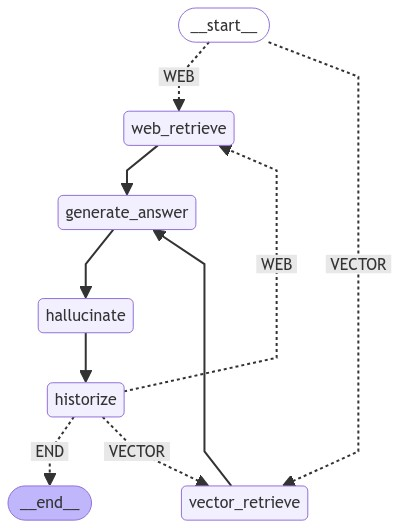

In [23]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(app.get_graph().draw_png()))

```mermaid

flowchart TD
    R0[route_expert]
    R0E[after route]
    WEB[web_retrieve]
    VEC[vector_retrieve]
    G[generate_answer]
    HALL[hallucinate]
    HIST[historize]
    ABORT
    END

    R0 --> R0E
    R0E -->|그게 아닐 때| WEB
    R0E -->|LLM agents, prompt engineering, and adversarial attacks 관련일 때| VEC
    VEC -->G
    WEB -->G
    G --> HALL
    HALL --> HIST

    HIST -->|3회 이하의 hallucinate| R0E
    HIST -->|3회 이상 시도했는데 hallucinate 일때| ABORT
    HIST -->|성공| END


  
```